In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.3 MB/s eta 0:00:00


In [3]:
from keras.datasets import imdb
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Input, BatchNormalization, Bidirectional

import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
edges = pd.read_csv("/content/drive/MyDrive/Projekt_SSN/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
features = pd.read_csv("/content/drive/MyDrive/Projekt_SSN/elliptic_bitcoin_dataset/elliptic_txs_features.csv",header=None)
classes = pd.read_csv("/content/drive/MyDrive/Projekt_SSN/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")

In [5]:
features.rename(columns = {0:'txId1'}, inplace = True)
features = pd.merge(features, edges.groupby('txId1').count(), on="txId1", how="left")
features.head()

,txId1,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,txId2
0,230425980,1,-0.056189,-0.175567,-1.185821,-0.186390,-0.046514,-0.167505,-0.101009,-0.133295,...,-0.582752,1.442895,1.440189,0.003514,-0.092606,-0.135784,-0.101068,-0.102834,-0.102128,1.0
1,5530458,1,-0.056193,-0.175567,-1.185821,-0.186390,-0.046514,-0.167505,-0.101009,-0.133311,...,0.702410,-1.033609,-1.032884,0.003514,-0.092606,-0.135784,-0.101068,-0.102834,-0.102128,1.0
2,232022460,1,-0.056378,-0.175567,-1.185821,-0.186390,-0.046514,-0.167505,-0.101009,-0.133972,...,0.467009,-1.033609,-1.032884,-0.106566,-0.113936,-0.135784,-0.186659,-0.102834,-0.102128,2.0
3,232438397,1,0.043005,0.743641,-0.644127,2.874647,-0.068726,2.304311,3.142835,-0.134902,...,-0.595477,0.204643,0.203652,0.994235,0.099367,-0.135784,0.669253,-0.102834,-0.102128,1.0
4,230460314,1,0.294595,-0.131268,-1.185821,0.125213,0.375512,0.188604,-0.101009,-0.134776,...,-0.380435,0.484856,0.546219,0.003514,0.312670,0.369103,1.281230,0.201809,0.202687,8.0


In [6]:
y = classes[classes['class'] != 'unknown']
x = features[features.iloc[:, 0].isin(y['txId'])]
x = x.iloc[:, 2:]
x.fillna(0, inplace=True)
y['class']=y['class'].apply(lambda x: x=='1')
y = y.iloc[:, 1]
x_train, x_test, y_train, y_test= train_test_split(x,y)
y_train.head()

<ipython-input-6-3fde43f3ce7d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['class']=y['class'].apply(lambda x: x=='1')


192638    False
99808     False
89033     False
126099    False
155900    False
Name: class, dtype: bool

In [7]:
x_train['txId2']=x_train['txId2'].apply(lambda x: np.log(1+x))
x_train.head()

,2,3,4,5,6,7,8,9,10,11,...,158,159,160,161,162,163,164,165,166,txId2
192638,-0.056636,-0.058579,1.522650,-0.186390,-0.046514,-0.167505,-0.101009,-0.134888,-0.089391,-0.024475,...,0.670599,-1.033609,-1.032884,-0.106566,0.206019,0.633566,0.455275,-1.775510,-1.775746,0.693147
99808,-0.056281,-0.075894,-1.185821,-0.168061,-0.046514,-0.146557,-0.101009,-0.134883,-0.088698,-0.021464,...,-0.391887,-1.033609,-1.032884,0.003514,-0.092606,-0.135784,-0.101068,-0.102834,-0.102128,0.000000
89033,-0.056519,-0.137171,0.439262,-0.168061,-0.046514,-0.146557,-0.101009,-0.134735,-0.089254,-0.024249,...,-0.589114,1.442895,1.440189,-0.106566,-0.092606,-0.084494,-0.143864,1.569841,1.571490,0.000000
126099,-0.056617,-0.157762,0.980956,-0.168061,-0.046514,-0.146557,-0.101009,-0.134894,-0.089362,-0.024336,...,0.002569,-1.033609,-1.032884,0.003514,-0.092606,-0.135784,-0.101068,-0.102834,-0.102128,0.693147
155900,0.154940,-0.114426,0.980956,-0.186390,-0.046514,-0.167505,-0.101009,0.622796,0.330549,-0.024475,...,-0.595477,0.204643,0.203652,0.003514,-0.092606,-0.135784,-0.101068,-0.102834,-0.102128,0.693147


(array([4.6556e+04, 4.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0. ,  47.2,  94.4, 141.6, 188.8, 236. , 283.2, 330.4, 377.6,
        424.8, 472. ]),
 <BarContainer object of 10 artists>)

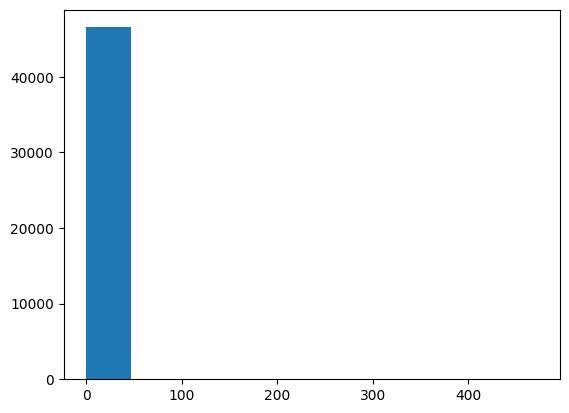

In [ ]:
plt.hist(x['txId2'])

(array([8.8120e+03, 2.4668e+04, 8.4900e+02, 3.7000e+02, 1.7100e+02,
        4.3000e+01, 6.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([0.        , 0.56664267, 1.13328534, 1.69992801, 2.26657068,
        2.83321334, 3.39985601, 3.96649868, 4.53314135, 5.09978402,
        5.66642669]),
 <BarContainer object of 10 artists>)

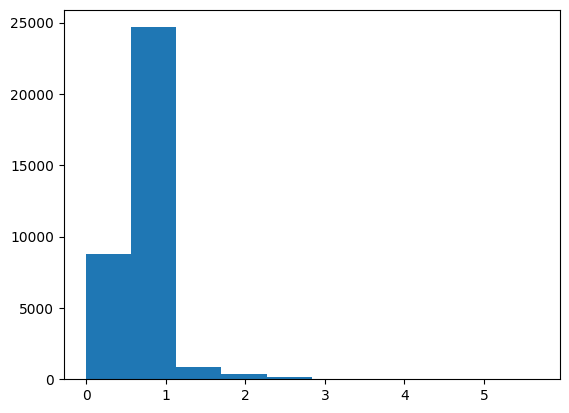

In [ ]:
plt.hist(x_train['txId2'])

In [14]:
def create_test_model(metric):
  return_data = {
      "metric": metric,
      "loss": 0,
      "metric_result": 0,
      "ratio": 0
  }
  model = Sequential()


  model.add(Bidirectional(LSTM(64, return_sequences=False),
                             input_shape=(x_train.shape[1], 1)))

  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss=['binary_crossentropy'] , optimizer='adam', metrics=[metric])

  print("Training model with metric: ", metric)
  model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

  print("Evaluating model with metric: ", metric)
  loss, metric2 = model.evaluate(x_test, y_test)
  return_data["loss"] = loss
  return_data["metric_result"] = metric2

  y = classes[classes['class'] == 'unknown']
  x = features[features.iloc[:, 0].isin(y['txId'])]
  x = x.iloc[:, 2:]
  x.fillna(0, inplace=True)
  x['txId2']=x['txId2'].apply(lambda x: np.log(1+x))

  print("Predicting on model with metric: ", metric)
  result=model.predict(x)

  res=np.round(result)
  unique, counts = np.unique(res, return_counts=True)

  return_data["ratio"] = counts[1]/counts[0]
  print("Ratio for model with metric ", metric, " is :", return_data["ratio"])
  return return_data


In [9]:
Accuracy_model = create_test_model("Accuracy")

Training model with metric:  Accuracy
Epoch 1/5
1092/1092 [==============================] - 27s 16ms/step - loss: 0.2737 - Accuracy: 0.9065 - val_loss: 0.2660 - val_Accuracy: 0.9043
Epoch 2/5
1092/1092 [==============================] - 21s 19ms/step - loss: 0.2271 - Accuracy: 0.9154 - val_loss: 0.2031 - val_Accuracy: 0.9200
Epoch 3/5
1092/1092 [==============================] - 18s 16ms/step - loss: 0.1894 - Accuracy: 0.9375 - val_loss: 0.1863 - val_Accuracy: 0.9338
Epoch 4/5
1092/1092 [==============================] - 17s 16ms/step - loss: 0.1807 - Accuracy: 0.9426 - val_loss: 0.2224 - val_Accuracy: 0.9181
Epoch 5/5
1092/1092 [==============================] - 17s 16ms/step - loss: 0.1798 - Accuracy: 0.9432 - val_loss: 0.2094 - val_Accuracy: 0.9181
Evaluating model with metric:  Accuracy
364/364 [==============================] - 3s 8ms/step - loss: 0.2094 - Accuracy: 0.9181
Predicting on model with metric:  Accuracy
4913/4913 [==============================] - 32s 6ms/step
Ratio f

In [10]:
Poisson_model = create_test_model("Poisson")

Training model with metric:  Poisson
Epoch 1/5
1092/1092 [==============================] - 22s 17ms/step - loss: 0.2576 - poisson: 0.2733 - val_loss: 0.2070 - val_poisson: 0.2367
Epoch 2/5
1092/1092 [==============================] - 18s 17ms/step - loss: 0.2290 - poisson: 0.2514 - val_loss: 0.2201 - val_poisson: 0.2419
Epoch 3/5
1092/1092 [==============================] - 17s 16ms/step - loss: 0.2224 - poisson: 0.2454 - val_loss: 0.2102 - val_poisson: 0.2342
Epoch 4/5
1092/1092 [==============================] - 17s 16ms/step - loss: 0.2012 - poisson: 0.2300 - val_loss: 0.1869 - val_poisson: 0.2187
Epoch 5/5
1092/1092 [==============================] - 17s 15ms/step - loss: 0.1810 - poisson: 0.2178 - val_loss: 0.1873 - val_poisson: 0.2209
Evaluating model with metric:  Poisson
364/364 [==============================] - 3s 7ms/step - loss: 0.1873 - poisson: 0.2209
Predicting on model with metric:  Poisson
4913/4913 [==============================] - 32s 6ms/step
Ratio for model with 

In [11]:
Hinge_model = create_test_model("Hinge")

Training model with metric:  Hinge
Epoch 1/5
1092/1092 [==============================] - 24s 17ms/step - loss: 0.2660 - hinge: 1.0542 - val_loss: 0.2317 - val_hinge: 1.0340
Epoch 2/5
1092/1092 [==============================] - 17s 16ms/step - loss: 0.2365 - hinge: 1.0353 - val_loss: 0.2295 - val_hinge: 1.0295
Epoch 3/5
1092/1092 [==============================] - 18s 16ms/step - loss: 0.2181 - hinge: 1.0269 - val_loss: 0.1974 - val_hinge: 1.0218
Epoch 4/5
1092/1092 [==============================] - 17s 16ms/step - loss: 0.2063 - hinge: 1.0199 - val_loss: 0.1956 - val_hinge: 1.0018
Epoch 5/5
1092/1092 [==============================] - 17s 16ms/step - loss: 0.1854 - hinge: 1.0043 - val_loss: 0.2105 - val_hinge: 1.0100
Evaluating model with metric:  Hinge
364/364 [==============================] - 3s 9ms/step - loss: 0.2105 - hinge: 1.0100
Predicting on model with metric:  Hinge
4913/4913 [==============================] - 33s 7ms/step
Ratio for model with metric  Hinge  is : 0.034880

In [15]:
Precision_model = create_test_model("Precision")

Training model with metric:  Precision
Epoch 1/5
1092/1092 [==============================] - 26s 17ms/step - loss: 0.3130 - precision: 0.1818 - val_loss: 0.2975 - val_precision: 0.0000e+00
Epoch 2/5
1092/1092 [==============================] - 16s 15ms/step - loss: 0.2980 - precision: 0.4688 - val_loss: 0.2321 - val_precision: 0.0000e+00
Epoch 3/5
1092/1092 [==============================] - 17s 15ms/step - loss: 0.2272 - precision: 0.6691 - val_loss: 0.1895 - val_precision: 0.7741
Epoch 4/5
1092/1092 [==============================] - 16s 14ms/step - loss: 0.1756 - precision: 0.8033 - val_loss: 0.1740 - val_precision: 0.7619
Epoch 5/5
1092/1092 [==============================] - 21s 19ms/step - loss: 0.1581 - precision: 0.8202 - val_loss: 0.1530 - val_precision: 0.7607
Evaluating model with metric:  Precision
364/364 [==============================] - 2s 6ms/step - loss: 0.1530 - precision: 0.7607
Predicting on model with metric:  Precision
4913/4913 [==============================] 

In [17]:
binary_crossentropy_model = create_test_model("binary_crossentropy")

Training model with metric:  binary_crossentropy
Epoch 1/5
1092/1092 [==============================] - 21s 15ms/step - loss: 0.2703 - binary_crossentropy: 0.2703 - val_loss: 0.2071 - val_binary_crossentropy: 0.2071
Epoch 2/5
1092/1092 [==============================] - 15s 14ms/step - loss: 0.2174 - binary_crossentropy: 0.2174 - val_loss: 0.2711 - val_binary_crossentropy: 0.2711
Epoch 3/5
1092/1092 [==============================] - 16s 14ms/step - loss: 0.2043 - binary_crossentropy: 0.2043 - val_loss: 0.1672 - val_binary_crossentropy: 0.1672
Epoch 4/5
1092/1092 [==============================] - 16s 15ms/step - loss: 0.2115 - binary_crossentropy: 0.2115 - val_loss: 0.1996 - val_binary_crossentropy: 0.1996
Epoch 5/5
1092/1092 [==============================] - 16s 14ms/step - loss: 0.1881 - binary_crossentropy: 0.1881 - val_loss: 0.1673 - val_binary_crossentropy: 0.1673
Evaluating model with metric:  binary_crossentropy
364/364 [==============================] - 2s 6ms/step - loss: 0.